# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

### План работ

* Загрузка данных
* Провести Исследовательский анализ, посроить графики, сделать выводы.
* Привести данные по необходимости к нужным типа. 
* Проверить и обработать пропуски
* Сформировать список вопросов заказчику
* Избавиться от выбросов
* Определить признаки 
* Объеденить таблицы с формированием признаков
* Отбросить не полные партии
* Сделать обучающую и тестовую выборки
* Подобрать лучшую модель из нескольких
* Проверить модель на тестовой выборке 
* Сделать выводы 



### Исследовательский анализ

In [22]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from datetime import  timedelta
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error


In [23]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [24]:
display(data_arc.head(10))
data_arc.info()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


В таблицек data_arc содержатся данные об нагреве электродами. Пропусков в данных нету, не верный тип столбцов с датой и временем 

In [25]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [26]:
data_arc.describe(include='all')

/tmp/ipykernel_32/575940407.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_arc.describe(include='all')
/tmp/ipykernel_32/575940407.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_arc.describe(include='all')


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,14875,14876,NaN,NaN
top,NaN,2019-06-10 22:02:03,2019-05-30 03:24:14,NaN,NaN
freq,NaN,2,1,NaN,NaN
first,NaN,2019-05-03 11:02:14,2019-05-03 11:06:02,NaN,NaN
last,NaN,2019-09-01 04:34:47,2019-09-01 04:36:08,NaN,NaN
mean,1615.220422,NaN,NaN,0.670441,0.452592
std,934.571502,NaN,NaN,0.408159,5.878702
min,1.000000,NaN,NaN,0.030002,-715.504924
25%,806.000000,NaN,NaN,0.395297,0.290991


Проверим кол-во отрицательных значений в столбце Реактивная мощность

In [27]:
data_arc[data_arc['Реактивная мощность']< 0].count()

key                     1
Начало нагрева дугой    1
Конец нагрева дугой     1
Активная мощность       1
Реактивная мощность     1
dtype: int64

Можем удалить эту строчку 

In [28]:
data_arc = data_arc[data_arc['Реактивная мощность']>= 0]

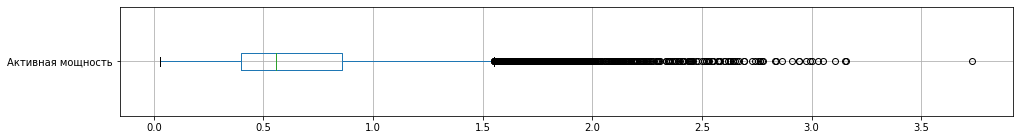

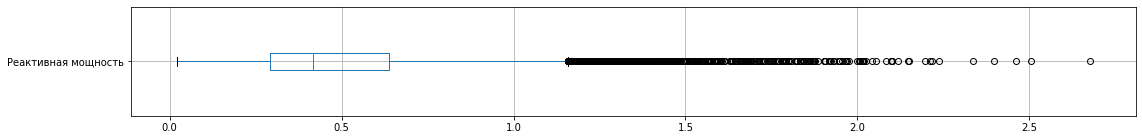

In [29]:
plt.figure(figsize=(16, 2))
data_arc.boxplot('Активная мощность', vert=False)
plt.show()
plt.figure(figsize=(18, 2))
data_arc.boxplot('Реактивная мощность', vert=False)
plt.show()

Согласно boxplot есть некоторое количество выбросов, но это скорей всего нормальные значение которые просто редко используются. Можно уточнить это у заказчика.

In [30]:
display(data_bulk.head(10))
data_bulk.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [31]:
data_bulk.describe(include='all')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


data_bulk содержит данные о подаче сыпучих материалов (объём). Есть преднамеренные пропуски, которые означают что тот или иной материал не использовался. Так же некоторые материалы использоватилсь очень редко, думаю их можно отбросить

In [32]:
data_bulk.count().sort_values(ascending=False)/data_bulk.shape[0]

key        1.000000
Bulk 14    0.896772
Bulk 12    0.782998
Bulk 15    0.718440
Bulk 3     0.414829
Bulk 4     0.324065
Bulk 6     0.184084
Bulk 1     0.080537
Bulk 11    0.056568
Bulk 10    0.056248
Bulk 5     0.024609
Bulk 7     0.007990
Bulk 2     0.007031
Bulk 9     0.006072
Bulk 13    0.005753
Bulk 8     0.000320
dtype: float64

Возможно отбросим те что использовались меньше чем в 5% случаем, а именно 'Bulk 5' 'Bulk 7' 'Bulk 2' 'Bulk 9' 'Bulk 13' 'Bulk 8'.

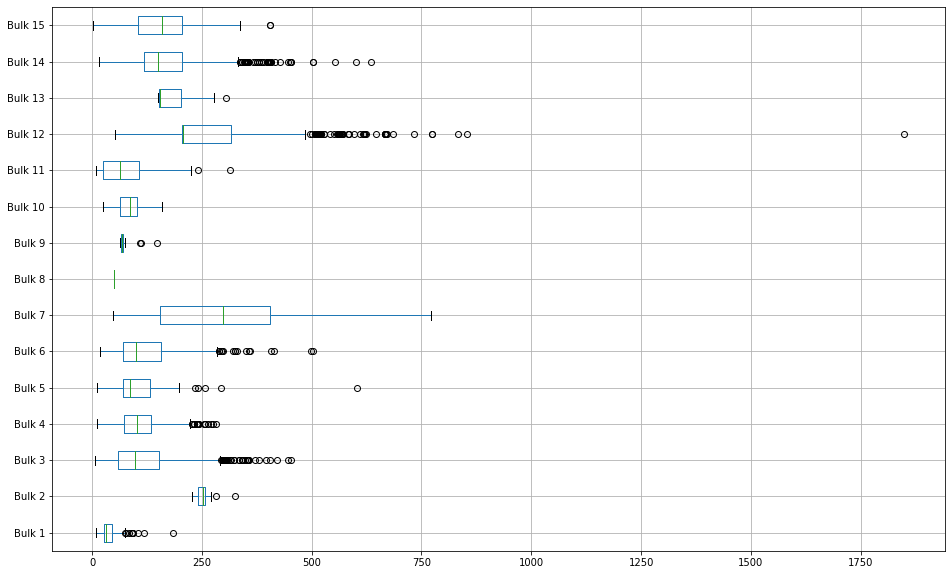

In [33]:
plt.figure(figsize=(16, 10))
data_bulk.drop(['key'], axis=1).boxplot(vert=False)
plt.show()

Как видим есть не много выбросов, но данные скорей всего корректные , избавимся только от максимального значения Bulk 12  уж очень оно большое.

In [34]:
data_bulk = data_bulk.drop(data_bulk['Bulk 12'].max(),axis=False)

In [35]:
display(data_bulk_time.head(10))
data_bulk_time.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


data_bulk_time связана с таблицей data_bulk , ничего не обычного не видно , разве что надо привести типы таднных с нужным.

In [36]:
for i in data_bulk_time.columns.drop(['key']):
    data_bulk_time[i] = pd.to_datetime(data_bulk_time[i], format='%Y-%m-%d %H:%M:%S')

In [37]:
display(data_gas.head(10))
data_gas.info()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков нету, типы данных корректны.

In [38]:
data_gas.describe(include='all')

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


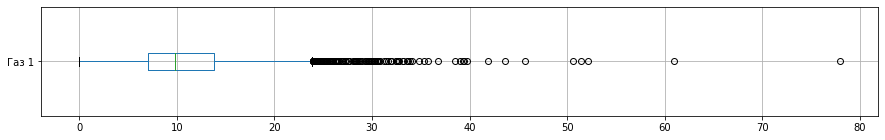

In [39]:
plt.figure(figsize=(15,2))
data_gas.boxplot('Газ 1',vert=False)
plt.show()

Опять видем выбросы, и некоторые давольно значительные.

In [40]:
display(data_temp.head(11))
data_temp.info()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [41]:
data_temp.describe(include='all')

,key,Время замера,Температура
count,15907.000000,15907,13006.000000
unique,NaN,15907,NaN
top,NaN,2019-07-18 16:42:17,NaN
freq,NaN,1,NaN
mean,1607.880870,NaN,1591.840920
std,942.212073,NaN,21.375851
min,1.000000,NaN,1191.000000
25%,790.000000,NaN,1581.000000
50%,1618.000000,NaN,1591.000000
75%,2427.000000,NaN,1601.000000


data_temp содержит целивую метрику. Есть пропуски, нужно оставить только те партии где есть начальная и конечная температура, промежуточные замеры нас не интересуют. Нужно привести столбец Время замера к нужному типу.

In [42]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

In [43]:
#Создадим таблицы с первым и последним измерением температуры
data_temp_last = (data_temp.groupby('key')
                  .apply(lambda x: x.loc[x['Время замера'] == x['Время замера'].max(),['Время замера','Температура']])
                  .rename(columns = {'Время замера':'last_time', 'Температура':'last_temp'}))
data_temp_first = (data_temp.groupby('key')
                   .apply(lambda x: x.loc[x['Время замера'] == x['Время замера'].min(),['Время замера','Температура']])
                   .rename(columns = {'Время замера':'first_time', 'Температура':'first_temp'}))

In [44]:
#Очистим пропуски
data_temp_last = data_temp_last.dropna()
data_temp_first = data_temp_first.dropna()

In [45]:
#Объеденим таблицы
data_temp_new = data_temp_first.merge(data_temp_last, on='key', how='inner')

data_temp_new.head()

,first_time,first_temp,last_time,last_temp
key,,,,
1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0


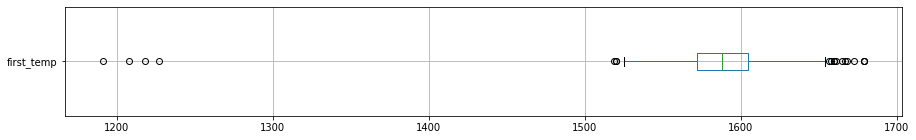

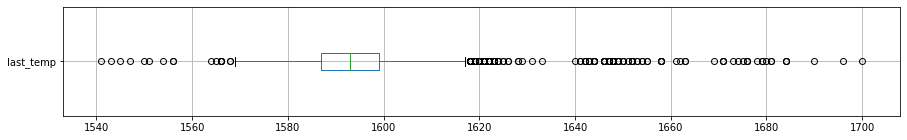

In [46]:
plt.figure(figsize=(15,2))
data_temp_new.boxplot('first_temp',vert=False)
plt.show()
plt.figure(figsize=(15,2))
data_temp_new.boxplot('last_temp',vert=False)
plt.show()

При первом измерении температуры есть подозрительно низкие значения, нужно уточнить.

In [47]:
display(data_wire.head(10))
data_wire.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [48]:
data_wire.describe(include='all')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


data_wire содержит данные о проволочных материалах (объём).Есть преднамеренные пропуски, которые означают что тот или иной материал не использовался. Так же некоторые материалы использоватилсь очень редко, думаю их можно отбросить.

In [49]:
data_wire.count().sort_values(ascending=False)/data_wire.shape[0]

key       1.000000
Wire 1    0.991561
Wire 2    0.350211
Wire 6    0.023694
Wire 3    0.020448
Wire 9    0.009413
Wire 8    0.006167
Wire 4    0.004544
Wire 7    0.003570
Wire 5    0.000325
dtype: float64

Возможно отбросим те что использовались меньше чем в 5% случаем, а именно 'Wire 6' 'Wire 3'  'Wire 9' 'Wire 8' 'Wire 4' 'Wire 7' 'Wire 5'.

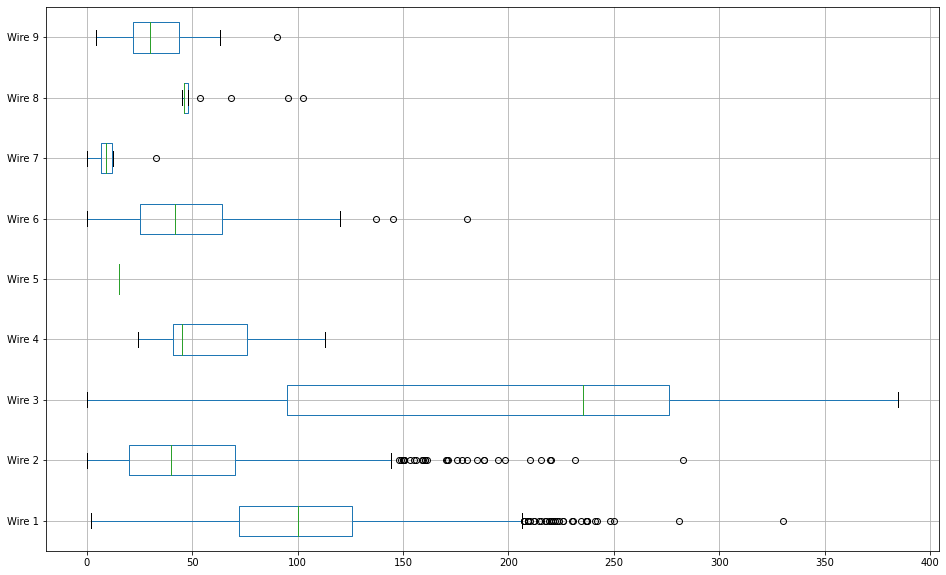

In [50]:
plt.figure(figsize=(16, 10))
data_wire.drop(['key'], axis=1).boxplot(vert=False)
plt.show()

Как видим есть не много выбросов, но данные скорей всего корректные.

In [51]:
display(data_wire_time.head(10))
data_wire_time.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


data_wire_time связана с таблицей data_wire, ничего не обычного не видно , разве что надо привести типы таднных с нужным.

In [53]:
for i in data_wire_time.columns.drop(['key']):
    data_wire_time[i] = pd.to_datetime(data_wire_time[i], format='%Y-%m-%d %H:%M:%S')

### Выводы

Не все данные корректны , присутствуют пропуски особенно актуально в таблице с замерами температуры. Есть выбросы почти везде, 
что с ними делать надо уточнить у заказчика. Данные разбиты на много таблиц которые в последствие надо собрать в одну и опеределить необходисые признаки. Присутствуют материалы как сыпучие так и проволочные которые используют очень редко.
В температуре есть слишком низкие значения.

### Список вопросов заказчику

* Нормальны ли выбросы в активной и реактивной мощности или могли быть сбои в работе или при заполнении данных.
* Можно ли не учитывать в обучении данные о сыпучих и проволочных материалах которые использовались реже чем в 5% случаев.
* Узнать нормально ли то что некоторые материалы иногда используются в объемах привышающих средние в 3 и более раз.
* Нормально ли в редких случаях использование газа в несколько раз превышающее средние значения.
* Можно ли объеденить все сыпучие материалы в один признак и все проволочные в другой суммируя по партиям.
* Уточнить допустимый минимум при первом измерении температуры.

<font color='blue'><b>Комментарий тимлида</b>
<br>Ответ на 1 вопрос:
<br>Это реальный процесс, очень часто бывают значения за пределами статистической нормы, только технологи точно знаю, может так дуга работать или нет. С отрицательной реактивной мощностью - точно ошибка, ее можно удалить
    
<br>Ответ на 2 вопрос:
<br>Тут лучше это провести, как эксперимент, насколько влияют редкие добавки на температуру процесса. Ты можешь использовать любое сочетание признаков, главное обосновывать, почему они есть/добавлены/удалены  
    
<br>Ответ на 3 вопрос:
<br>Да, чаще всего используется одна категория примесей, например, для популярной марки стали, которую льют чаще всего
    
<br>Ответ на 4 вопрос:
<br>Вополне, это реальный тех процесс, в котором нужно подавать ровно столько, сколько потребуется
    
<br>Ответ на 5 вопрос:
<br>Как и во втором вопросе - здесь нет ограничения создавать новые признаки на основе других, главное пояснить их суть
    
<br>Ответ на 6 вопрос:
<br> Подробности можешь смотреть здесь http://mfina.ru/temperatura-plavleniya-stali/. Но мы ориентируемся, что готовятся стандартные марки стали с температурой в диапазоне 1420 — 1525 градусов Цельсия. Поэтому температуры ниже 1400 можно считать аномалиями.
    
</font>

Избавимся от партий где первые замеры показали температуру ниже 1400, они больше похожи на ошибочные.

In [54]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   first_time  2477 non-null   datetime64[ns]
 1   first_temp  2477 non-null   float64       
 2   last_time   2477 non-null   datetime64[ns]
 3   last_temp   2477 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.8 KB


In [55]:
data_temp_new = data_temp_new[data_temp_new['first_temp'] > 1400]

### Определим признаки

* Первое измерение температуры
* Кол-во и вид поданых сыпучих материалов
* Кол-во и вид поданых проволочных материалов
* Данные о продувке газом
* Сумма Полных мощность итераций нагрева для каждой партии, формула для расчета полной мощности:  $Полная Мощность = \sqrt[2]{(Реактивная Мощность)^2+(Активная Мощность)^2}$
* Суммарное Время всех итераций нагрева для каждой партии

### Объеденить таблицы с формированием признаков

Заменим пропуски в таблицах с кол-вом сыпучих и проволочных материалов нулями.

In [56]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

Посчитам время и полную мощность каждой итерации нагрева.

In [57]:
data_arc_new = pd.DataFrame(data_arc['key'])
data_arc_new['time'] = ((data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой'])
                        .apply(timedelta.total_seconds)
                        .astype('int'))
data_arc_new['power'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)


data_arc_new = round(data_arc_new.groupby('key').sum(), 2)

In [58]:
data_arc_new.head(10)

,time,power
key,,
1,1098,5.83
2,811,3.65
3,655,2.99
4,741,3.81
5,869,4.04
6,952,4.79
7,673,2.99
8,913,4.63
9,625,2.56


Объеденим таблицы

In [59]:
pd.set_option('display.max_columns', None)

data = pd.DataFrame(data_temp_new[['first_temp','last_temp']])
data = data.merge(data_bulk,  on='key', how='inner')
data = data.merge(data_wire,  on='key', how='inner')
data = data.merge(data_gas,  on='key', how='inner')
data = data.merge(data_arc_new,  on='key', how='inner')


Проверим корреляцию.

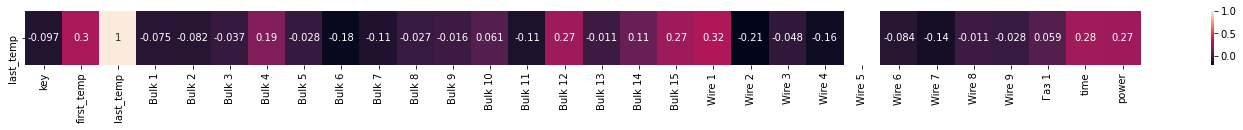

In [60]:
plt.figure(figsize=(25, 1))
sns.heatmap(data.corr()[2:3], annot = True)
plt.show()

Подозрительные данные в 'Wire 5'.

In [61]:
data['Wire 5'].sum()

0.0

Избавимся от него

In [62]:
data = data.drop(columns='Wire 5')

По результату корреляционного анализа видим что никаких прямых зависимостей нету. После чистки в колонке 'Wire 5' не осталось данных поэтому сы избавились от неё. 

### Сделаем обучающую и тестовую выборки

In [63]:
# Заранее определим переменную random_state
random_state = 160123

Выделяем признаки и цели , и делим данные на тестовые и тренировочные в соотношении 3:1

In [64]:
features = data.drop(columns='last_temp',axis=True)
target = data['last_temp']

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                           test_size=0.25, random_state=random_state)

### Подберём лучшую модель из нескольких

Создадим функцию для подбора моделий спомощью GridSearchCV возвращает DF с моделью параметрами и лучшем итогом mae. 

In [65]:
results = pd.DataFrame(columns=['model','parametrs','mae'])

# Функция для подьбора параметров 
def trainer (model_train, parameters):
    model = GridSearchCV(model_train, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs = -1, verbose=10)
    results = pd.DataFrame(columns=['model','parametrs','mae'])
    
    model.fit(features_train,target_train)

    results = results.append({'model': model_train,
                              'parametrs': model.best_params_,
                              'mae': -model.best_score_}, ignore_index=True) 

    
    return results

In [66]:
data[['first_temp','last_temp']].describe()

,first_temp,last_temp
count,2324.000000,2324.000000
mean,1587.347676,1593.366609
std,23.613175,11.211957
min,1519.000000,1541.000000
25%,1571.000000,1587.000000
50%,1587.000000,1593.000000
75%,1603.000000,1598.000000
max,1660.000000,1653.000000


Среднее занчение первого и последнего измерение очень близки. для константной модели можем взять среднее от первого измерения.

In [73]:
predictions = pd.DataFrame(columns=['mean_temp'],index=range(0, target_test.shape[0]))

predictions['mean_temp'] = round(features_train['first_temp'].mean())

print('MAE Константной модели:', mean_absolute_error(target_test,predictions))

MAE Константной модели: 9.912220309810671


Так же поппробуем средлнее значение последнего измерения температуры.

In [72]:
predictions = pd.DataFrame(columns=['mean_temp'],index=range(0, target_test.shape[0]))

predictions['mean_temp'] = round(target_train.mean())

print('MAE Константной модели:', mean_absolute_error(target_test,predictions))

MAE Константной модели: 8.390705679862306


DecisionTreeRegressor

In [48]:
parametrs = {'max_depth': range(100, 501, 100),'random_state': [random_state]}
model = DecisionTreeRegressor()
results = results.append(trainer(model,parametrs),  ignore_index=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START max_depth=100, random_state=160123..........................
[CV 1/5; 1/5] END ........max_depth=100, random_state=160123; total time=   0.1s
[CV 2/5; 1/5] START max_depth=100, random_state=160123..........................
[CV 2/5; 1/5] END ........max_depth=100, random_state=160123; total time=   0.0s
[CV 3/5; 1/5] START max_depth=100, random_state=160123..........................
[CV 3/5; 1/5] END ........max_depth=100, random_state=160123; total time=   0.0s
[CV 4/5; 1/5] START max_depth=100, random_state=160123..........................
[CV 4/5; 1/5] END ........max_depth=100, random_state=160123; total time=   0.0s
[CV 5/5; 1/5] START max_depth=100, random_state=160123..........................
[CV 5/5; 1/5] END ........max_depth=100, random_state=160123; total time=   0.0s
[CV 1/5; 2/5] START max_depth=200, random_state=160123..........................
[CV 1/5; 2/5] END ........max_depth=200, random_s

RandomForestRegressor

In [47]:
parametrs = {'n_estimators': range(100, 501, 100),'max_depth': range(5, 16, 5),'random_state': [random_state]}
model = RandomForestRegressor()
results = results.append(trainer(model,parametrs),  ignore_index=True)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START max_depth=5, n_estimators=100, random_state=160123.........
[CV 1/5; 1/15] END max_depth=5, n_estimators=100, random_state=160123; total time=   0.4s
[CV 2/5; 1/15] START max_depth=5, n_estimators=100, random_state=160123.........
[CV 2/5; 1/15] END max_depth=5, n_estimators=100, random_state=160123; total time=   0.4s
[CV 3/5; 1/15] START max_depth=5, n_estimators=100, random_state=160123.........
[CV 3/5; 1/15] END max_depth=5, n_estimators=100, random_state=160123; total time=   0.4s
[CV 4/5; 1/15] START max_depth=5, n_estimators=100, random_state=160123.........
[CV 4/5; 1/15] END max_depth=5, n_estimators=100, random_state=160123; total time=   0.4s
[CV 5/5; 1/15] START max_depth=5, n_estimators=100, random_state=160123.........
[CV 5/5; 1/15] END max_depth=5, n_estimators=100, random_state=160123; total time=   0.4s
[CV 1/5; 2/15] START max_depth=5, n_estimators=200, random_state=160123.........
[CV

LGBMRegressor

In [48]:
parametrs = {'n_estimators': range(100, 201, 100),
             'max_depth': range(6, 11, 2),
             'learning_rate':[0.1],
             'random_state': [random_state]}

model = LGBMRegressor()
results = results.append(trainer(model,parametrs),  ignore_index=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 1/5; 1/6] END learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123; total time=   0.6s
[CV 2/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 2/5; 1/6] END learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123; total time=   0.6s
[CV 3/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 3/5; 1/6] END learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123; total time=   0.7s
[CV 4/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 4/5; 1/6] END learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123; total time=   0.6s
[CV 5/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 5/5; 1/6] END learning_rate=0.1, max_depth=6, n_estima

CatBoostRegressor

In [49]:
parametrs = {'n_estimators': range(100, 201, 100),
             'max_depth': range(6, 11, 2),
             'learning_rate': [0.1],
             'random_state': [random_state]}

model = CatBoostRegressor(verbose=False)
results = results.append(trainer(model,parametrs),  ignore_index=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 1/5; 1/6] END learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123; total time=   1.1s
[CV 2/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 2/5; 1/6] END learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123; total time=   0.8s
[CV 3/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 3/5; 1/6] END learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123; total time=   0.8s
[CV 4/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 4/5; 1/6] END learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123; total time=   0.7s
[CV 5/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 5/5; 1/6] END learning_rate=0.1, max_depth=6, n_estima

XGBRegressor

In [50]:
parametrs = {'n_estimators': range(100, 201, 100),
             'max_depth': range(6, 11, 2),
             'learning_rate': [0.1],
             'random_state': [random_state]}
model = XGBRegressor()
results = results.append(trainer(model,parametrs),  ignore_index=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 1/5; 1/6] END learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123; total time=   2.9s
[CV 2/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 2/5; 1/6] END learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123; total time=   2.9s
[CV 3/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 3/5; 1/6] END learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123; total time=   3.2s
[CV 4/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 4/5; 1/6] END learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123; total time=   3.0s
[CV 5/5; 1/6] START learning_rate=0.1, max_depth=6, n_estimators=100, random_state=160123
[CV 5/5; 1/6] END learning_rate=0.1, max_depth=6, n_estima

In [51]:
pd.set_option('display.max_colwidth', -1)
display(results.sort_values(by='mae'))


/tmp/ipykernel_352/882371403.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,model,parametrs,mae
3,<catboost.core.CatBoostRegressor object at 0x7f8a4dd4c130>,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'random_state': 160123}",5.979787
4,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,\n scale_pos_weight=None, subsample=None, tree_method=None,\n validate_parameters=None, verbosity=None)","{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'random_state': 160123}",6.005398
2,LGBMRegressor(),"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'random_state': 160123}",6.074526
1,RandomForestRegressor(),"{'max_depth': 15, 'n_estimators': 400, 'random_state': 160123}",6.084710
0,DecisionTreeRegressor(),"{'max_depth': 100, 'random_state': 160123}",8.365466


In [53]:
model = CatBoostRegressor(learning_rate=0.1, max_depth=6, n_estimators=200,verbose=0, random_state=random_state)
model.fit(features_train,target_train)
predictions = model.predict(features_test)
print('MAE лучшей модели на тестовой выборке:', mean_absolute_error(target_test,predictions))

MAE лучшей модели на тестовой выборке: 6.120871910066263


### Вывод

Лучший результат показала модель CatBoostRegressor с параметрами learning_rate=0.1, max_depth=6, n_estimators=200,verbose=0, итоговый результат на тестовой модели МАЕ = 6.12. Результат константной модели МАЕ = 9.03. Худший результат в свою очередь показала модель DecisionTreeRegressor что ожидаемо. 

* Какие пункты плана были выполнены, а какие — нет. Почему?

Все пункты плана были выполнены.

* Какие трудности возникли и как вы их преодолели?

Самое трудное провести иссле́довательский анализ данных и разобраться в незнакомой сфере.

* Какие ключевые шаги в решении задачи вы выделили?

Разобраться в сфере работы заказчика.

Очистка данных и их исследование.

Предобработка данных.

Опеределение признаков.

Подбор модели.

Проверка на тестовой выборке.

* Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?

Тмпература первого измерения. Удалены пропуски , оставлены только партии с первым и последним измерением, удалены выброс с слишком низкими температурами.

Все данные об объеме сыпучих материалов. Пропуски заменены на 0, удалены значения которые могли исказить модели и могли быть не адекватными.

Все данные об объеме проволочных материалов. Пропуски заменены на 0, удален столбец 'Wire 5' про причине отсутствия данных после обработки.

Данные о продувек газом.

Общее время нагрева. Высчитаны из данных таблицы data_arc

Сумаррная полная мощность нагрева. Высчитаны из данных таблицы data_arc по формуле:$Полная Мощность = \sqrt[2]{(Реактивная Мощность)^2+(Активная Мощность)^2}$

* Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?

Итоговая модель CatBoostRegressor, параметры learning_rate=0.1, max_depth=6, n_estimators=200,verbose=0, на тестовой модели МАЕ = 6.12